In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
from scipy.stats import norm

import os
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfork_funcs import emulator, nested_sampler



import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2025-02-24 14:41:26.550700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 14:41:26.561889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 14:41:26.565345: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 14:41:27.124303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/tmp/ipykernel_180693/2578786877.py:155: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


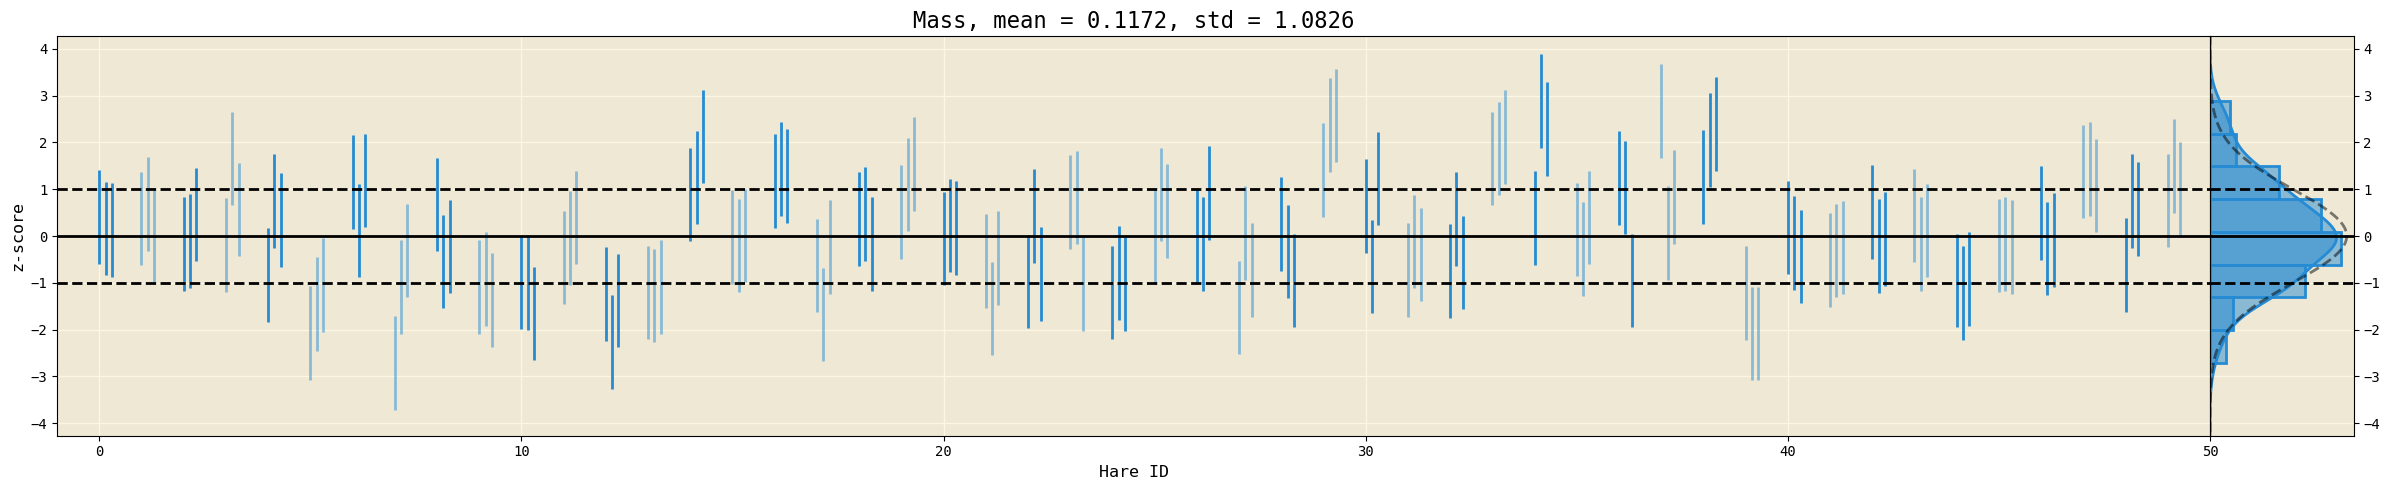

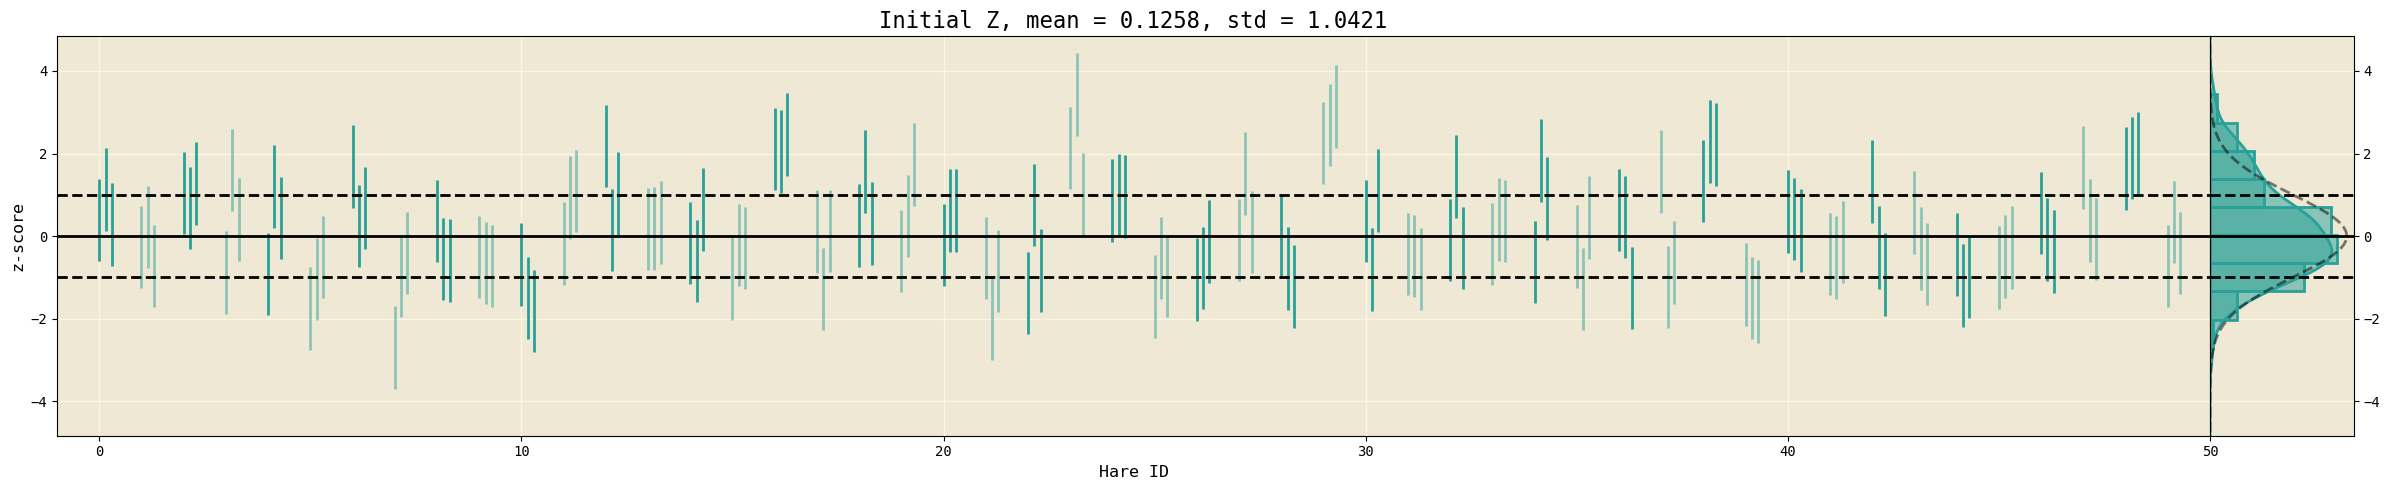

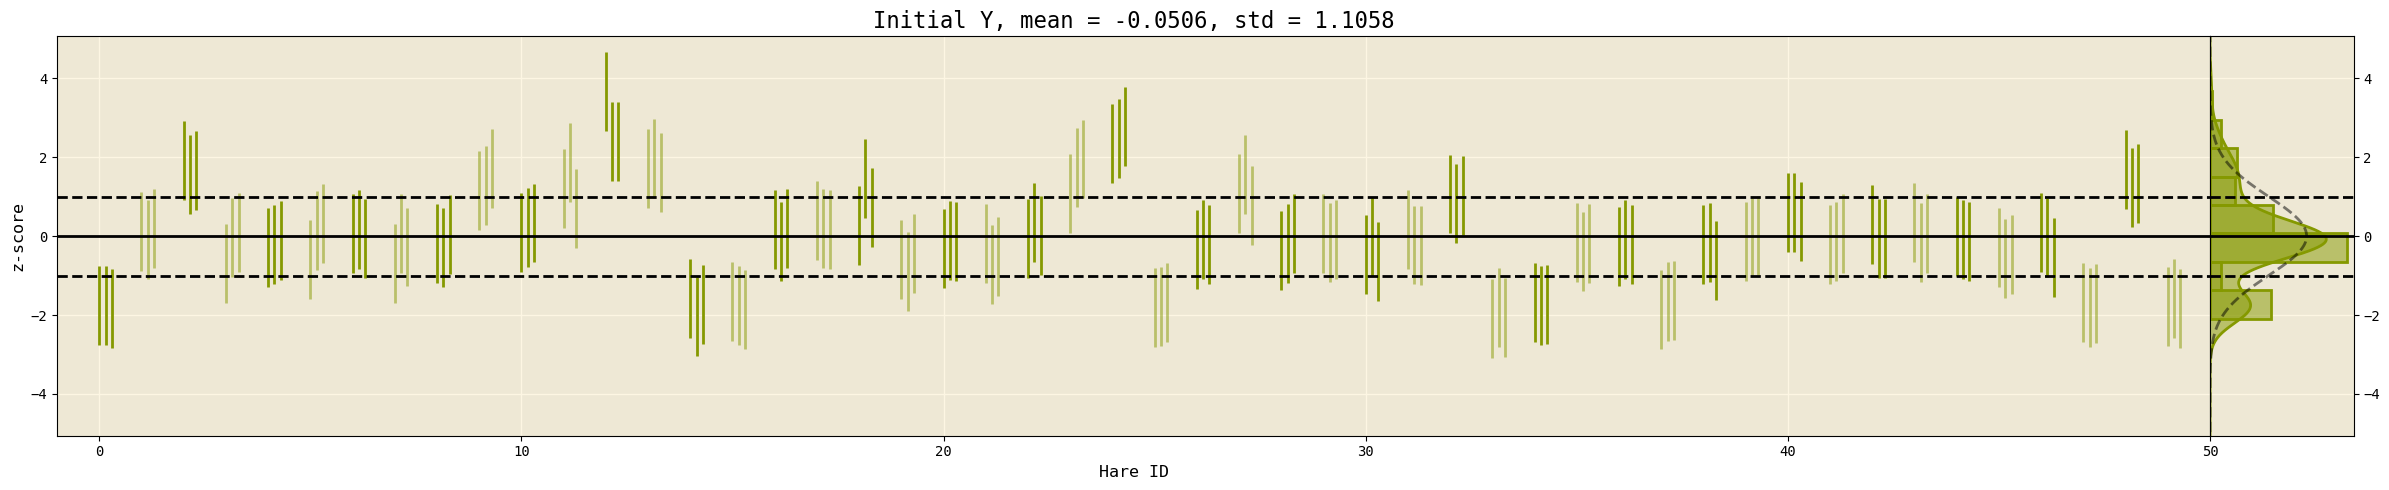

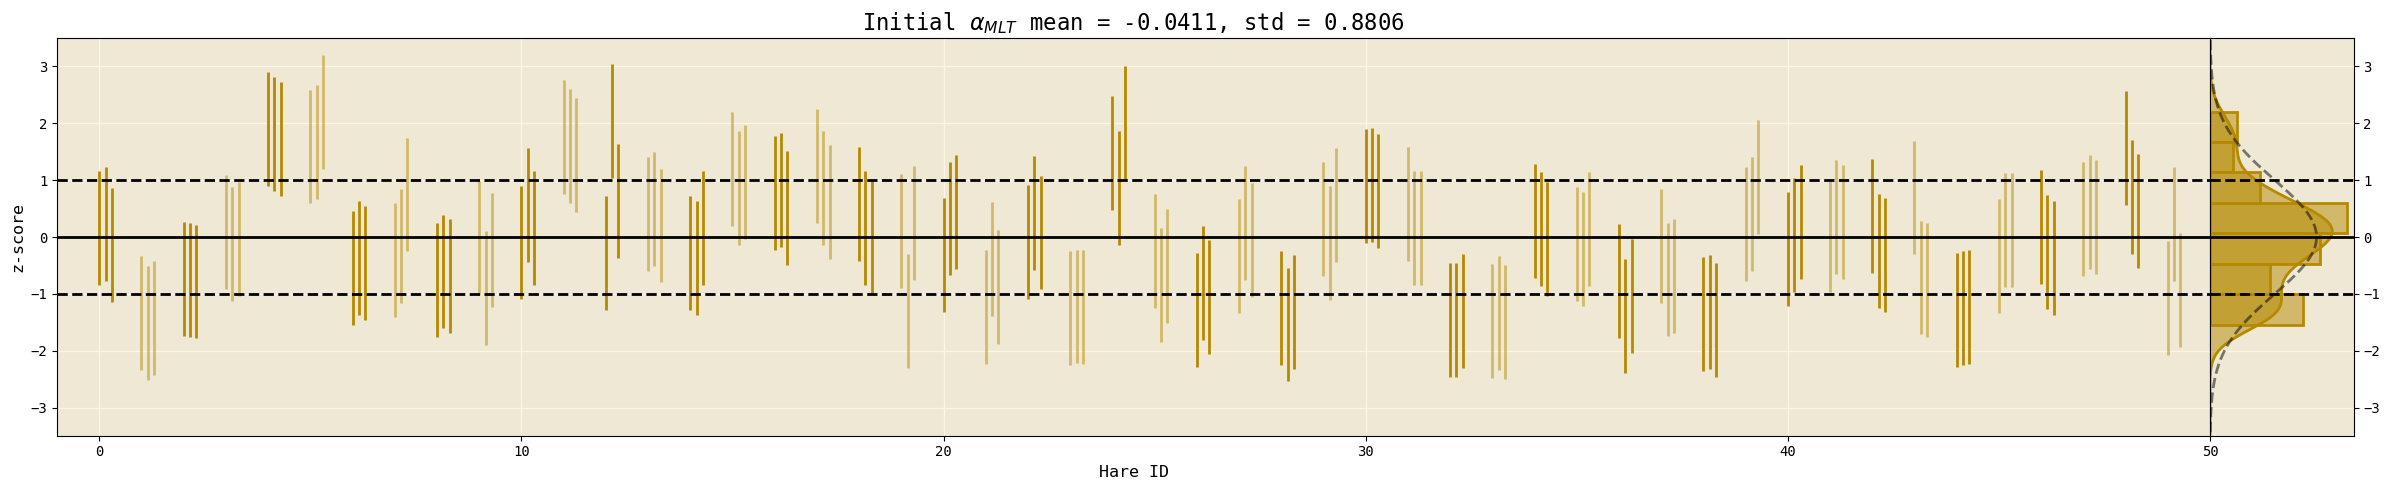

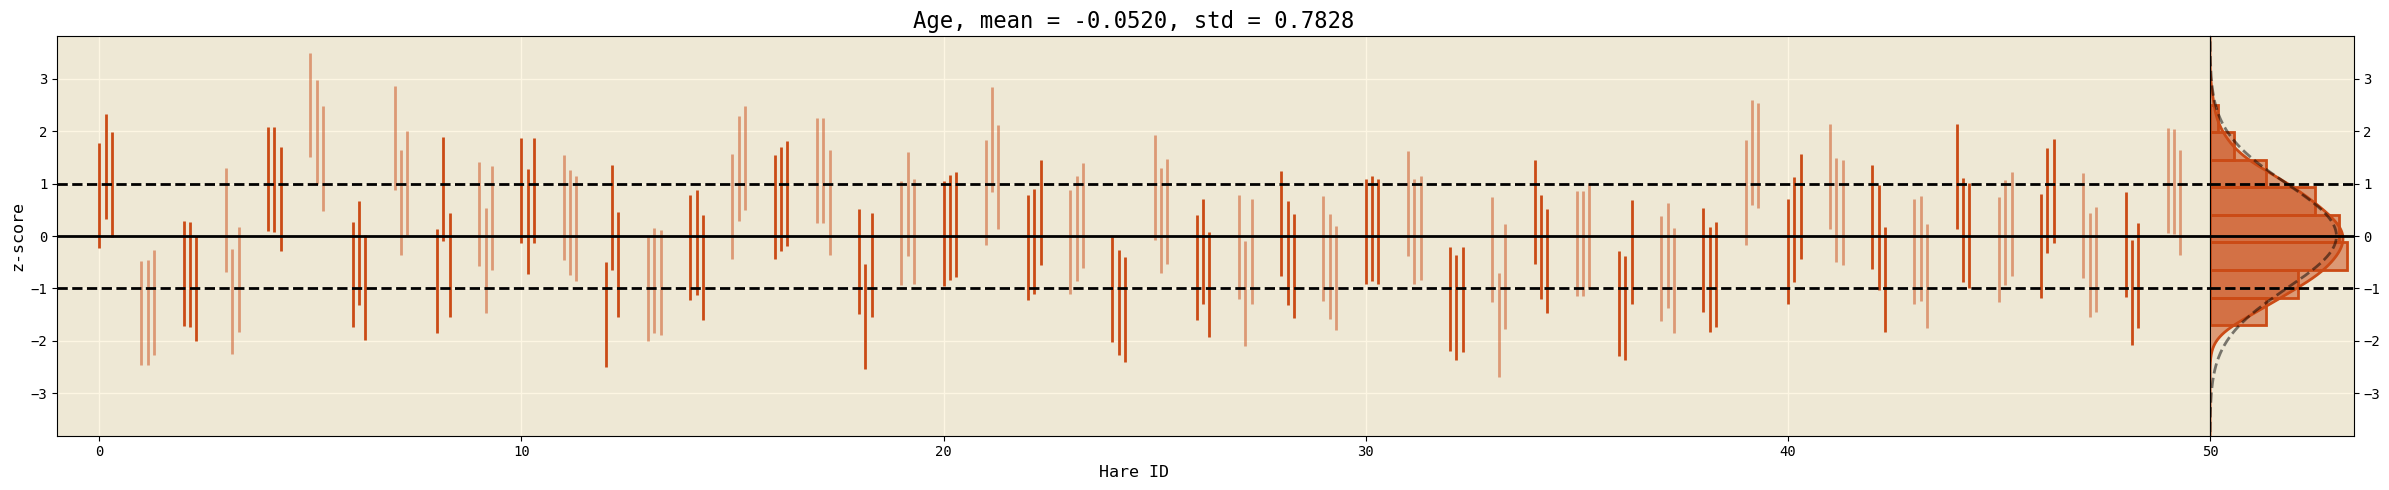

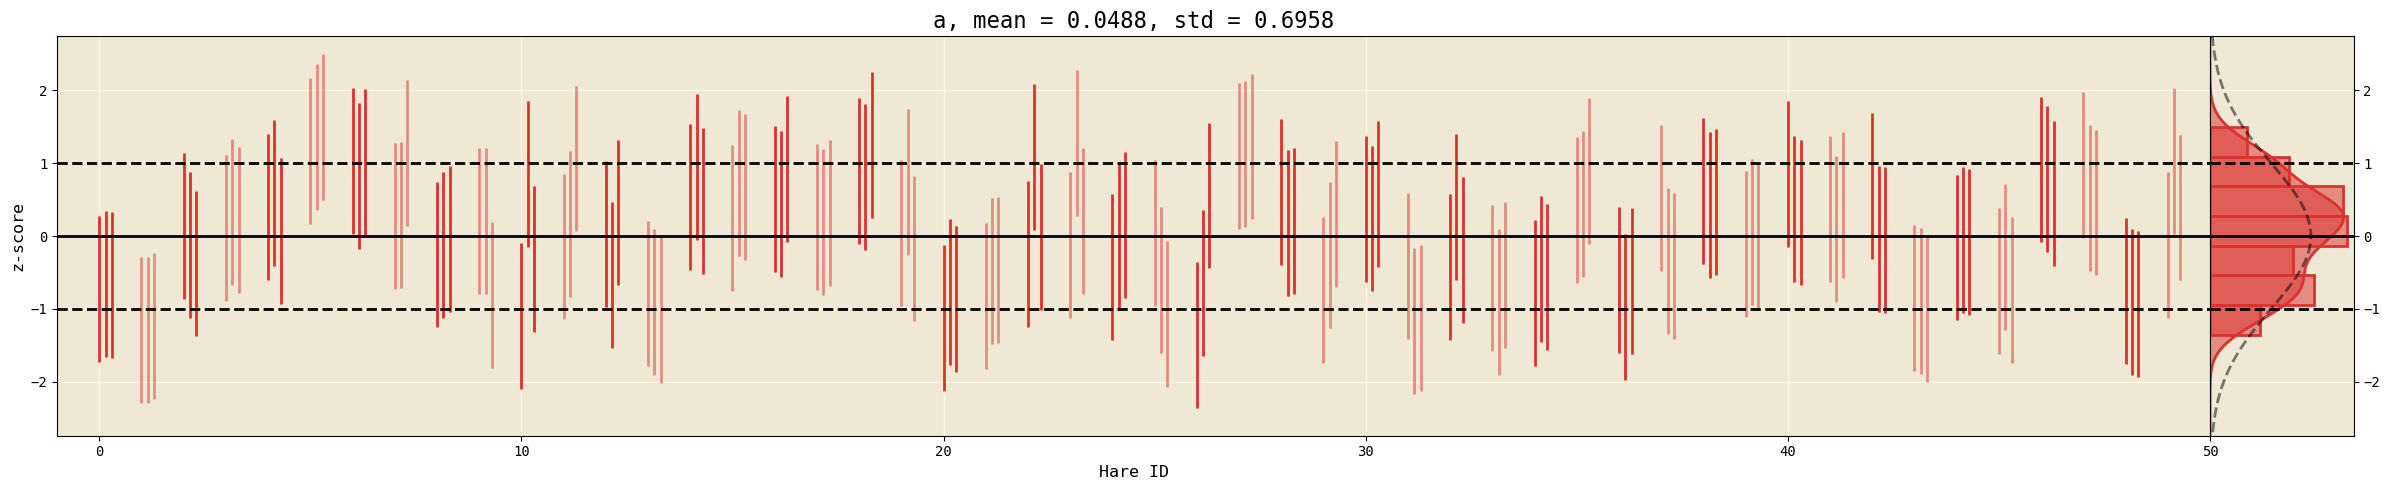

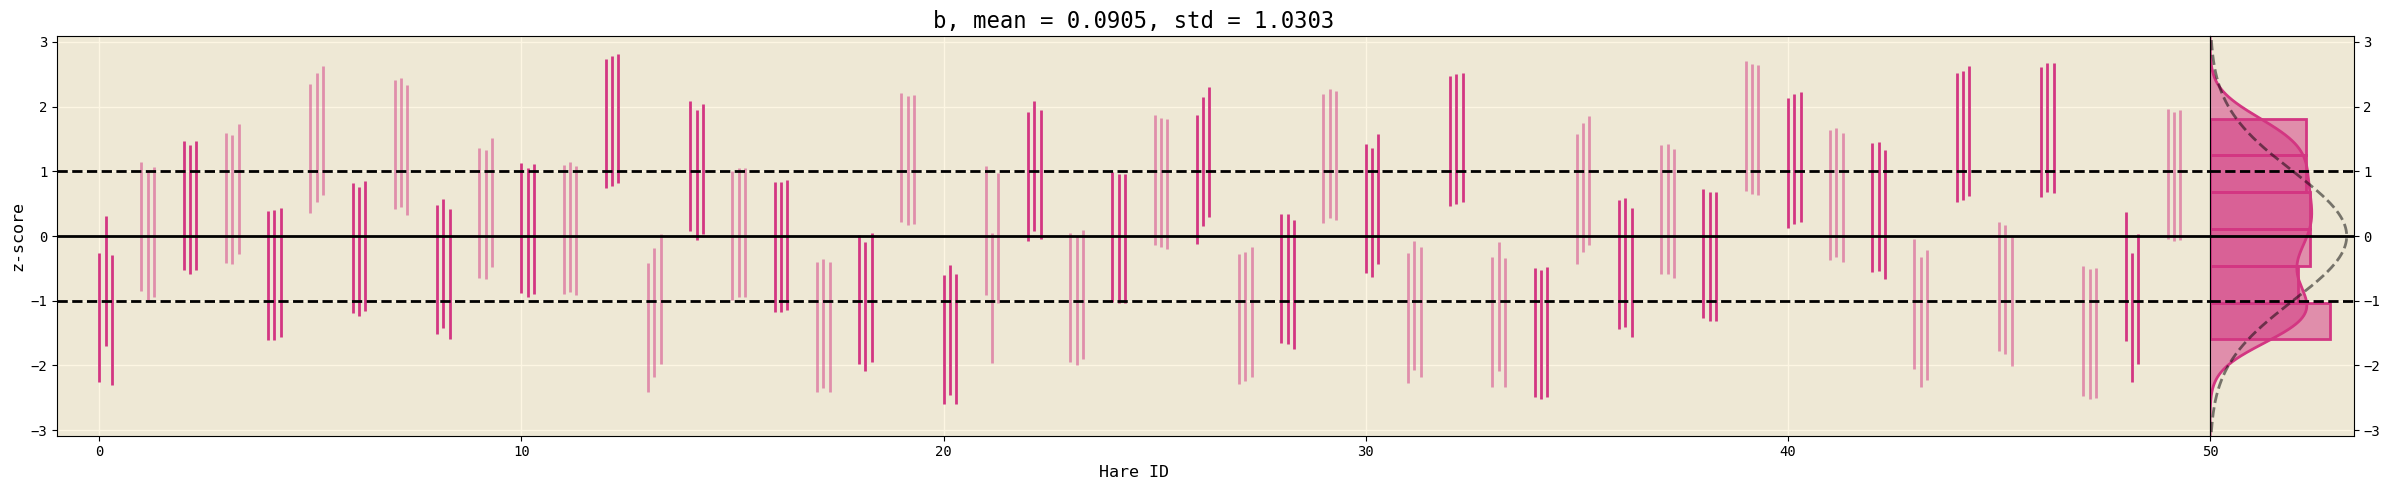

In [3]:
hares_observed = 50

obs_range = 3

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

zscores_dict = {}

for label in inputs:
    zscores_dict[f'{label}_zscores'] = np.empty(1)

for obs_idx in range(obs_range):
    zscores_dict[f'obs{obs_idx}'] = {}
    zscore_upper_array=np.empty((0,7))
    zscore_mean_array=np.empty((0,7))
    zscore_lower_array=np.empty((0,7))
    for hare_idx in range(hares_observed):
        path = f'form/hare{hare_idx}/obs{obs_idx}/'
        
        with open(path+'samples.pkl', 'rb') as fp:
             samples = pickle.load(fp)
        

        samples = samples['samples']
        
        samples_df = pd.DataFrame(samples, columns = inputs)
        
        hare_df = pd.read_json(path+f'obs{obs_idx}.json')[inputs]
        
        zscore_upper_row = np.empty(len(inputs))
        zscore_mean_row = np.empty(len(inputs))
        zscore_lower_row = np.empty(len(inputs))
        
        array_idx = 0
        for label in inputs:
            samples_label = samples_df[label]
            hare_label = hare_df[label]
        
            samples_std = samples_label.std()
            
            zscore_dist = (hare_label.values[0] - samples_label)/samples_std

            zscore_mean = zscore_dist.mean()
            
            zscore_std = zscore_dist.std()
        
            zscore_upper_row[array_idx] = zscore_mean + zscore_std

            zscore_mean_row[array_idx] = zscore_mean
    
            zscore_lower_row[array_idx] = zscore_mean - zscore_std

            zscores_dict[f'{label}_zscores'] = np.append(zscores_dict[f'{label}_zscores'], zscore_dist.values)
            
            array_idx+=1
    
        zscore_upper_array = np.vstack([zscore_upper_array, zscore_upper_row])
        zscore_mean_array = np.vstack([zscore_mean_array, zscore_mean_row])
        zscore_lower_array = np.vstack([zscore_lower_array, zscore_lower_row])
    
    zscores_dict[f'obs{obs_idx}']['zscore_upper_df'] = pd.DataFrame(zscore_upper_array, columns = inputs)
    zscores_dict[f'obs{obs_idx}']['zscore_mean_df'] = pd.DataFrame(zscore_mean_array, columns = inputs)
    zscores_dict[f'obs{obs_idx}']['zscore_lower_df'] = pd.DataFrame(zscore_lower_array, columns = inputs)

#colors = ['r', 'b', 'g', 'c', 'm']
colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

label_idx = 0
for label in inputs:
    fig, (ax,ax1) = plt.subplots(1,2, figsize=(24,5), width_ratios=(15,1), layout='compressed')
    z_score_means_array = np.array([])
    for obs_idx in range(obs_range):
        zscore_lower_df = zscores_dict[f'obs{obs_idx}']['zscore_lower_df']
        zscore_mean_df = zscores_dict[f'obs{obs_idx}']['zscore_mean_df']
        zscore_upper_df = zscores_dict[f'obs{obs_idx}']['zscore_upper_df']

        z_score_means_array = np.concatenate((z_score_means_array,zscore_mean_df[label].values))
        for i in range(hares_observed):
            x_val = i+(obs_idx*0.15)
            if i%2 == 0:
                ax.plot(np.full(2, x_val), np.array([zscore_lower_df[label].values[i], zscore_upper_df[label].values[i]]), c=colours[label_idx])
            else:
                ax.plot(np.full(2, x_val), np.array([zscore_lower_df[label].values[i], zscore_upper_df[label].values[i]]), c=colours[label_idx], alpha=0.5)

        
    ax.axhline(0, c='black')
    ax.axhline(-1, c='black', linestyle='--')
    ax.axhline(1, c='black', linestyle='--')
    
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax.set_xlim(xmin=-1, xmax=hares_observed)



    ax1.hist(z_score_means_array, orientation='horizontal', density=True, color=colours[label_idx], bins='scott', alpha=0.5)
    ax1.hist(z_score_means_array, orientation='horizontal', density=True, facecolor="none", bins='scott', alpha=1, edgecolor=colours[label_idx], linewidth=2)
    
    kde= scipy.stats.gaussian_kde(z_score_means_array)

    # zscores_sample = np.random.choice(zscores_dict[f'{label}_zscores'], size=10000, replace=False)

    # ax1.hist(zscores_sample, orientation='horizontal', density=True, color=colours[label_idx], bins='scott', alpha=0.5)
    # ax1.hist(zscores_sample, orientation='horizontal', density=True, facecolor="none", bins='scott', alpha=1, edgecolor=colours[label_idx], linewidth=2)
    # kde= scipy.stats.gaussian_kde(zscores_sample, bw_method=0.5)
    
    kde_y = np.linspace(-20,20,10000)
    kde_x = kde(kde_y)
    ax1.plot(kde_x, kde_y,color=colours[label_idx])
    ax1.fill_between(kde_x, 0, kde_y, color=colours[label_idx], alpha=0.5)
    ax1.yaxis.tick_right()

    ax1.plot(norm.pdf(kde_y, loc=0, scale=1), kde_y, color = 'k', linestyle = '--', alpha=0.5)

    ax1.axhline(0, c='black')
    ax1.axhline(-1, c='black', linestyle='--')
    ax1.axhline(1, c='black', linestyle='--')
    ax1.set_xticks([])
    ax1.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax1.set_xlim(xmin=0)
        
    # mean = np.mean(zscores_dict[f'{label}_zscores'])
    # std = np.std(zscores_dict[f'{label}_zscores'])

    mean = zscore_mean_df[label].values.mean()
    std = zscore_mean_df[label].values.std()

    dp=4
    if label == "initial_mass":
        ax.set_title(rf"Mass, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "initial_Zinit":
        ax.set_title(f"Initial Z, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "initial_Yinit":
        ax.set_title(f"Initial Y, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "initial_MLT":
        ax.set_title(r"Initial $\alpha_{MLT}$"+f" mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "star_age":
        ax.set_title(f"Age, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "a":
        ax.set_title(f"a, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "b":
        ax.set_title(f"b, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    ax.set_xlabel("Hare ID")

    ax.set_ylabel("z-score")
    label_idx+=1

    plt.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.patch.set_alpha(0.0)
    #plt.savefig(f'figs/{label}_zscore.png', bbox_inches='tight')

In [ ]:
hares_observed = 50

obs_range = 3

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

zscores_dict = {}

for label in inputs:
    zscores_dict[f'{label}_zscores'] = np.empty(1)

for obs_idx in range(obs_range):
    zscores_dict[f'obs{obs_idx}'] = {}
    zscore_upper_array=np.empty((0,7))
    zscore_mean_array=np.empty((0,7))
    zscore_lower_array=np.empty((0,7))
    for hare_idx in range(hares_observed):
        path = f'form/hare{hare_idx}/obs{obs_idx}/'
        
        with open(path+'samples.pkl', 'rb') as fp:
             samples = pickle.load(fp)
        

        samples = samples['samples']
        
        samples_df = pd.DataFrame(samples, columns = inputs)
        
        hare_df = pd.read_json(path+f'obs{obs_idx}.json')[inputs]
        
        zscore_upper_row = np.empty(len(inputs))
        zscore_mean_row = np.empty(len(inputs))
        zscore_lower_row = np.empty(len(inputs))
        
        array_idx = 0
        for label in inputs:
            samples_label = samples_df[label]
            hare_label = hare_df[label]
        
            samples_std = samples_label.std()
            
            zscore_dist = (hare_label.values[0] - samples_label)/samples_std

            zscore_mean = zscore_dist.mean()
            
            zscore_std = zscore_dist.std()
        
            zscore_upper_row[array_idx] = zscore_mean + zscore_std

            zscore_mean_row[array_idx] = zscore_mean
    
            zscore_lower_row[array_idx] = zscore_mean - zscore_std

            zscores_dict[f'{label}_zscores'] = np.append(zscores_dict[f'{label}_zscores'], zscore_dist.values)
            
            array_idx+=1
    
        zscore_upper_array = np.vstack([zscore_upper_array, zscore_upper_row])
        zscore_mean_array = np.vstack([zscore_mean_array, zscore_mean_row])
        zscore_lower_array = np.vstack([zscore_lower_array, zscore_lower_row])
    
    zscores_dict[f'obs{obs_idx}']['zscore_upper_df'] = pd.DataFrame(zscore_upper_array, columns = inputs)
    zscores_dict[f'obs{obs_idx}']['zscore_mean_df'] = pd.DataFrame(zscore_mean_array, columns = inputs)
    zscores_dict[f'obs{obs_idx}']['zscore_lower_df'] = pd.DataFrame(zscore_lower_array, columns = inputs)

#colors = ['r', 'b', 'g', 'c', 'm']
colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

label_idx = 0
for label in inputs:
    fig, (ax,ax1) = plt.subplots(1,2, figsize=(24,5), width_ratios=(15,1), layout='compressed')
    z_score_means_array = np.array([])
    for obs_idx in range(obs_range):
        zscore_lower_df = zscores_dict[f'obs{obs_idx}']['zscore_lower_df']
        zscore_mean_df = zscores_dict[f'obs{obs_idx}']['zscore_mean_df']
        zscore_upper_df = zscores_dict[f'obs{obs_idx}']['zscore_upper_df']

        z_score_means_array = np.concatenate((z_score_means_array,zscore_mean_df[label].values))
        for i in range(hares_observed):
            x_val = i+(obs_idx*0.15)
            if i%2 == 0:
                ax.plot(np.full(2, x_val), np.array([zscore_lower_df[label].values[i], zscore_upper_df[label].values[i]]), c=colours[label_idx])
            else:
                ax.plot(np.full(2, x_val), np.array([zscore_lower_df[label].values[i], zscore_upper_df[label].values[i]]), c=colours[label_idx], alpha=0.5)

        
    ax.axhline(0, c='black')
    ax.axhline(-1, c='black', linestyle='--')
    ax.axhline(1, c='black', linestyle='--')
    
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax.set_xlim(xmin=-1, xmax=hares_observed)


    
    
    # ax1.hist(zscores_dict[f'{label}_zscores'], orientation='horizontal', density=True, color=colours[label_idx], bins='scott', alpha=0.5)
    # ax1.hist(zscores_dict[f'{label}_zscores'], orientation='horizontal', density=True, facecolor="none", bins='scott', alpha=1, edgecolor=colours[label_idx], linewidth=2)
    
    # kde= scipy.stats.gaussian_kde(zscores_dict[f'{label}_zscores'], bw_method='scott')


    # ax1.hist(z_score_means_array, orientation='horizontal', density=True, color=colours[label_idx], bins='scott', alpha=0.5)
    # ax1.hist(z_score_means_array, orientation='horizontal', density=True, facecolor="none", bins='scott', alpha=1, edgecolor=colours[label_idx], linewidth=2)
    
    # kde= scipy.stats.gaussian_kde(z_score_means_array)

    zscores_sample = np.random.choice(zscores_dict[f'{label}_zscores'], size=10000, replace=False)

    ax1.hist(zscores_sample, orientation='horizontal', density=True, color=colours[label_idx], bins='scott', alpha=0.5)
    ax1.hist(zscores_sample, orientation='horizontal', density=True, facecolor="none", bins='scott', alpha=1, edgecolor=colours[label_idx], linewidth=2)
    kde= scipy.stats.gaussian_kde(zscores_sample, bw_method=0.5)
    
    kde_y = np.linspace(-20,20,10000)
    kde_x = kde(kde_y)
    ax1.plot(kde_x, kde_y,color=colours[label_idx])
    ax1.fill_between(kde_x, 0, kde_y, color=colours[label_idx], alpha=0.5)
    ax1.yaxis.tick_right()

    ax1.plot(norm.pdf(kde_y, loc=0, scale=1), kde_y, color = 'k', linestyle = '--', alpha=0.5)

    ax1.axhline(0, c='black')
    ax1.axhline(-1, c='black', linestyle='--')
    ax1.axhline(1, c='black', linestyle='--')
    ax1.set_xticks([])
    ax1.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax1.set_xlim(xmin=0)
        
    mean = np.mean(zscores_dict[f'{label}_zscores'])
    std = np.std(zscores_dict[f'{label}_zscores'])

    # mean = zscore_mean_df[label].values.mean()
    # std = zscore_mean_df[label].values.std()

    dp=4
    if label == "initial_mass":
        ax.set_title(rf"Mass, mean = {mean:.{dp}f}, std = {std:.{dp}f}, all samples")

    elif label == "initial_Zinit":
        ax.set_title(f"Initial Z, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "initial_Yinit":
        ax.set_title(f"Initial Y, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "initial_MLT":
        ax.set_title(r"Initial $\alpha_{MLT}$"+f" mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "star_age":
        ax.set_title(f"Age, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "a":
        ax.set_title(f"a, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    elif label == "b":
        ax.set_title(f"b, mean = {mean:.{dp}f}, std = {std:.{dp}f}")

    ax.set_xlabel("Hare ID")

    ax.set_ylabel("z-score")
    label_idx+=1

    plt.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.patch.set_alpha(0.0)
    #plt.savefig(f'figs/{label}_zscore.png', bbox_inches='tight')